# Graph Classification with TF-GNN

In this lab, we will do graph classification of molecules.

Each molecule is represented as a graph. Nodes correspond to atoms, and edges represent the bonds between them. This is one of the application areas where GNNs are now the method of choice.

We will use the MUTAG dataset, a common dataset from the [TUDatasets](https://chrsmrrs.github.io/datasets/) collection.

There are 188 graphs in this dataset, labeled with one of two classes, representing "their mutagenic effect on a specific gram negative bacterium". Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F, 4=I, 5=Cl, 6=Br). Edge features  represent the bond type.

Please note that this is an introductory example on homogeneous graphs (one node type, and one edge type). TF-GNN is designed to support heterogeneous graphs as well (multiple node types, and/or multiple edge types).

## Imports

Before Python can `import tensorflow_gnn`, the PIP package [`tensorflow-gnn`](https://pypi.org/project/tensorflow-gnn/) needs to be downloaded and installed.

In [ ]:
%%bash
pip install -q tensorflow-gnn
pip install -U numpy --force-reinstall 

**Restart Kernel**

#### Setup

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_gnn as tfgnn

print(f"Running TF-GNN {tfgnn.__version__} with TensorFlow {tf.__version__}.")

Running TF-GNN 0.2.0 with TensorFlow 2.9.1.


#### Define the `GraphTensorSpec`
The `GraphTensor` class is the cornerstone of the TF-GNN library. It is a composite tensor (like `RaggedTensor` or `SparseTensor`), so it can be used directly in a `tf.data.Dataset`, as an in put or output of a Keras layer, or a `tf.function`. 

The `GraphTensor` class represents heterogeneous directed graphs with attached features as a collection of `tf.Tensor` and/or `tf.RaggedTensor` objects. Since our data is stored in `.tfrecord` format, we can define a graph tensor spec and use that to decode the data. For this dataset our `GraphTensorSpec` will define a:
* `ContextSpec`: This is our binary classification label for each molecule.
* `NodeSetSpec`: A node set of our atoms. Each node is a single atom.
* `features_spec` represents the integer encoding of the atom type.
* `EdgeSetSpec`: A edge set representing the bonds of each molecule.

More detail about Graph Tensors:
* Node sets are simply containers of features, plus size information. Within each node set the nodes are indexed 0,1,...,n-1. All nodes in a node set have the same features, identified by a string key, and each feature is stored as one tensor for the whole node set with shape [n, ...]. The first dimension is the item dimension, its size is the number n of nodes. The remaining zero or more dimensions make up the feature shape, that is, the shape of the feature value for each node. If the feature is stored as a tf.Tensor, all feature values have the same shape. GraphTensor also supports storing the feature as a tf.RaggedTensor, which allows for variable-size feature values. This support for an arbitrary number of features, ragged or dense, makes GraphTensor a good fit for both input features (often more than one, possibly variable-length) and hidden states in a GNN (stored as a single feature under the name tfgnn.HIDDEN_STATE = "hidden_state").


* Each edge set contains edges that connect a particular pair of source and target node sets. (There can be more than one edge set between the same pair of node sets.) The edges in an edge set are indexed 0,1, ..., m–1. Like a node set, an edge set stores size information and a map of features, indexed by edge instead of node. Most importantly, though, each edge set has an EdgeSet.adjacency subobject to represent how this edge set connects nodes from its incident node sets. The basic tfgnn.Adjacency class stores two tensors .source and .target, each of shape [m], such that edge i connects nodes adjacency.source[i] and adjacency.target[i] of the node sets adjacency.source_name and adjacency.target_name. Code that treats the choice of incident node as a parameter can also spell these properties as adjacency[incident_node_tag] and adjacency.node_set_name[incident_node_tag] using the symbolic constants tfgnn.SOURCE or tfgnn.TARGET as tags to distinguish the two incident nodes of every edge.

In [2]:
# Define graph tensor spec
graph_tensor_spec = tfgnn.GraphTensorSpec.from_piece_specs(
    context_spec=tfgnn.ContextSpec.from_field_specs(
        features_spec={"label": tf.TensorSpec(shape=(1,), dtype=tf.int32)}
    ),
    node_sets_spec={
        "atoms": tfgnn.NodeSetSpec.from_field_specs(
            features_spec={
                "hidden_state": tf.TensorSpec((None, 7), tf.float32)
            },
            sizes_spec=tf.TensorSpec((1,), tf.int32),
        )
    },
    edge_sets_spec={
        "bonds": tfgnn.EdgeSetSpec.from_field_specs(
            features_spec={
                "hidden_state": tf.TensorSpec((None, 4), tf.float32)
            },
            sizes_spec=tf.TensorSpec((1,), tf.int32),
            adjacency_spec=tfgnn.AdjacencySpec.from_incident_node_sets(
                "atoms", "atoms"
            ),
        )
    },
)

Function to decode the `.tfrecord` data

In [3]:
def decode_fn(example):
    features_dict = {"graph": tf.io.FixedLenFeature([], dtype=tf.string)}

    parsed_example = tf.io.parse_single_example(
        serialized=example, features=features_dict
    )

    graph = tfgnn.parse_single_example(
        graph_tensor_spec, example, validate=True
    )

    # extract label from context and remove from input graph
    context_features = graph.context.get_features_dict()
    label = context_features.pop("label")
    new_graph = graph.replace_features(context=context_features)
    return new_graph, label

In [4]:
TRAIN_PATH = "../data/mutag/train.tfrecords"
VAL_PATH = "../data/mutag/val.tfrecords"

train_ds = tf.data.TFRecordDataset([TRAIN_PATH]).map(decode_fn)
val_ds = tf.data.TFRecordDataset([VAL_PATH]).map(decode_fn)

2022-07-06 22:23:11.501834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-07-06 22:23:11.501885: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 22:23:11.501919: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tf26-fresh-bois): /proc/driver/nvidia/version does not exist
2022-07-06 22:23:11.502379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Look at one example from the dataset

In [5]:
graph, label = train_ds.take(1).get_single_element()

#### Node features

Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F,
4=I, 5=Cl, 6=Br).

In [6]:
graph.node_sets["atoms"].features

{'hidden_state': <tf.Tensor: shape=(14, 7), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]], dtype=float32)>}

#### Bond Edges

In this example, we consider the bonds between atoms undirected edges. To encode
them in the GraphsTuple, we store the undirected edges as pairs of directed
edges in both directions.

`adjacency.source` contains the source node indices, and `adjacency.target` contains the corresponding target node indices.

In [7]:
graph.edge_sets["bonds"].adjacency.source

<tf.Tensor: shape=(28,), dtype=int32, numpy=
array([ 0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,
        6,  6,  7,  8,  9, 10, 11, 11, 11, 12, 13], dtype=int32)>

In [8]:
graph.edge_sets["bonds"].adjacency.target

<tf.Tensor: shape=(28,), dtype=int32, numpy=
array([ 1,  5,  0,  2, 11,  1,  3,  2,  4, 10,  3,  5,  9,  0,  4,  6,  5,
        7,  8,  6,  6,  4,  3,  1, 12, 13, 11, 11], dtype=int32)>

#### Edge features

Edge features represent the bond type as one-hot encoding.

In [9]:
graph.edge_sets["bonds"].features

{'hidden_state': <tf.Tensor: shape=(28, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)>}

### Label
The label is binary, indicating the mutagenicity of the molecule. It's either 0 or 1.

In [10]:
label

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>

#### Batch the datasets

In [11]:
batch_size = 32
train_ds_batched = train_ds.batch(batch_size=batch_size).repeat()
val_ds_batched = val_ds.batch(batch_size=batch_size)

### Build the GNN model

TF-GNN provides Keras layers for building graph neural networks. The following code uses Keras' [Functional API](https://www.tensorflow.org/guide/keras/functional) to build a model as a series of GraphTensor transformations, followed by reading out a plain Tensor with the final prediction.

In [12]:
def build_model(
    graph_tensor_spec,
    # Dimensions of initial states.
    node_dim=32,
    edge_dim=32,
    # Dimensions for message passing.
    message_dim=64,
    next_state_dim=64,
    # Dimension for the logits.
    num_classes=2,
    # Number of message passing steps.
    num_message_passing=5,
    # Other hyperparameters.
    l2_regularization=5e-3,
    dropout_rate=0.5,
):
    # Input
    input_graph = tf.keras.layers.Input(type_spec=graph_tensor_spec)

    # IMPORTANT: All TF-GNN modeling code assumes a GraphTensor of shape []
    # in which the graphs of the input batch have been merged to components of
    # one contiguously indexed graph. (There are no edges between components,
    # so no information flows between them.)
    graph = input_graph.merge_batch_to_components()

    # Nodes and edges have one-hot encoded input features. Sending them through
    # a Dense layer effectively does a lookup in a trainable embedding table.
    def set_initial_node_state(node_set, *, node_set_name):
        # Since we only have one node set, we can ignore node_set_name.
        return tf.keras.layers.Dense(node_dim)(node_set[tfgnn.HIDDEN_STATE])

    def set_initial_edge_state(edge_set, *, edge_set_name):
        return tf.keras.layers.Dense(edge_dim)(edge_set[tfgnn.HIDDEN_STATE])

    graph = tfgnn.keras.layers.MapFeatures(
        node_sets_fn=set_initial_node_state, edge_sets_fn=set_initial_edge_state
    )(graph)

    # This helper function is just a short-hand for the code below.
    def dense(units, activation="relu"):
        """A Dense layer with regularization (L2 and Dropout)."""
        regularizer = tf.keras.regularizers.l2(l2_regularization)
        return tf.keras.Sequential(
            [
                tf.keras.layers.Dense(
                    units,
                    activation=activation,
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer,
                ),
                tf.keras.layers.Dropout(dropout_rate),
            ]
        )

    # The GNN core of the model does `num_message_passing` many updates of node
    # states conditioned on their neighbors and the edges connecting to them.
    # More precisely:
    #  - Each edge computes a message by applying a dense layer `message_fn`
    #    to the concatenation of node states of both endpoints (by default)
    #    and the edge's own unchanging feature embedding.
    #  - Messages are summed up at the common TARGET nodes of edges.
    #  - At each node, a dense layer is applied to the concatenation of the old
    #    node state with the summed edge inputs to compute the new node state.
    # Each iteration of the for-loop creates new Keras Layer objects, so each
    # round of updates gets its own trainable variables.

    for i in range(num_message_passing):
        graph = tfgnn.keras.layers.GraphUpdate(
            node_sets={
                "atoms": tfgnn.keras.layers.NodeSetUpdate(
                    {
                        "bonds": tfgnn.keras.layers.SimpleConv(
                            sender_edge_feature=tfgnn.HIDDEN_STATE,
                            message_fn=dense(message_dim),
                            reduce_type="sum",
                            receiver_tag=tfgnn.TARGET,
                        )
                    },
                    tfgnn.keras.layers.NextStateFromConcat(
                        dense(next_state_dim)
                    ),
                )
            }
        )(graph)

    # After the GNN has computed a context-aware representation of the "atoms",
    # the model reads out a representation for the graph as a whole by averaging
    # (pooling) node states into the graph context. The context is global to each
    # input graph of the batch, so the first dimension of the result corresponds
    # to the batch dimension of the inputs (same as the labels).
    readout_features = tfgnn.keras.layers.Pool(
        tfgnn.CONTEXT, "mean", node_set_name="atoms"
    )(graph)

    # Put a linear classifier on top (not followed by dropout).
    logits = tf.keras.layers.Dense(1)(readout_features)

    # Build a Keras Model for the transformation from input_graph to logits.
    return tf.keras.Model(inputs=[input_graph], outputs=[logits])

#### Define Loss and Metrics

In [13]:
model_input_graph_spec, label_spec = train_ds.element_spec
del label_spec  # Unused.
model = build_model(model_input_graph_spec)

In [14]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [
    tf.keras.metrics.BinaryAccuracy(threshold=0.0),
    tf.keras.metrics.BinaryCrossentropy(from_logits=True),
]

#### Compile the keras model

In [15]:
model.compile(tf.keras.optimizers.Adam(), loss=loss, metrics=metrics)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 input.merge_batch_to_compon  ()                       0         
 ents (InstanceMethod)                                           
                                                                 
 map_features (MapFeatures)  ()                        416       
                                                                 
 graph_update (GraphUpdate)  ()                        12416     
                                                                 
 graph_update_1 (GraphUpdate  ()                       18560     
 )                                                               
                                                                 
 graph_update_2 (GraphUpdate  ()                       18560 

#### Train the model

In [17]:
history = model.fit(
    train_ds_batched,
    steps_per_epoch=15,
    epochs=200,
    validation_data=val_ds_batched,
)

Epoch 1/200


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/graph_update_4/node_set_update_4/simple_conv_4/Reshape_2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/graph_update_4/node_set_update_4/simple_conv_4/Reshape_1:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/graph_update_4/node_set_update_4/simple_conv_4/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/graph_update_4/node_set_update_4/simple_conv_4/Reshape_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/graph_update_4/node_

15/15 [==============================] - 4s 97ms/step - loss: 4.9609 - binary_accuracy: 0.6267 - binary_crossentropy: 0.7470 - val_loss: 4.6922 - val_binary_accuracy: 0.7632 - val_binary_crossentropy: 0.6163
Epoch 2/200
15/15 [==============================] - 1s 37ms/step - loss: 4.5804 - binary_accuracy: 0.6467 - binary_crossentropy: 0.6316 - val_loss: 4.4119 - val_binary_accuracy: 0.7368 - val_binary_crossentropy: 0.6157
Epoch 3/200
15/15 [==============================] - 1s 37ms/step - loss: 4.2906 - binary_accuracy: 0.6556 - binary_crossentropy: 0.6239 - val_loss: 4.1213 - val_binary_accuracy: 0.7368 - val_binary_crossentropy: 0.6070
Epoch 4/200
15/15 [==============================] - 1s 37ms/step - loss: 3.9901 - binary_accuracy: 0.6667 - binary_crossentropy: 0.6012 - val_loss: 3.8207 - val_binary_accuracy: 0.7368 - val_binary_crossentropy: 0.5780
Epoch 5/200
15/15 [==============================] - 1s 38ms/step - loss: 3.7267 - binary_accuracy: 0.6822 - binary_crossentropy: 0.

### Plot the loss and metric curves for train and val

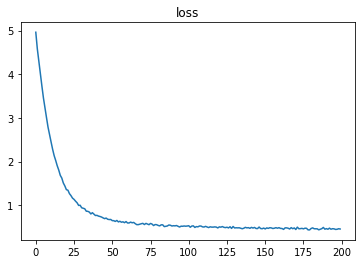

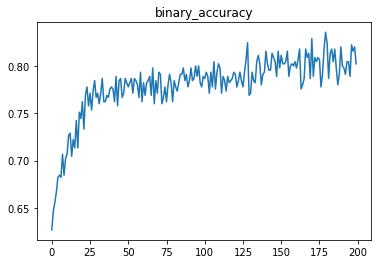

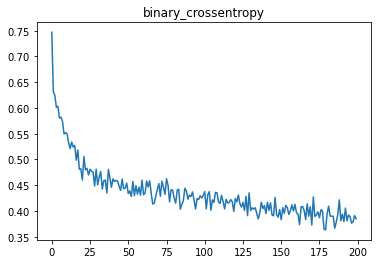

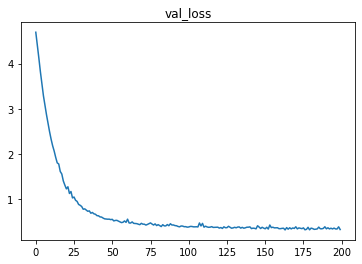

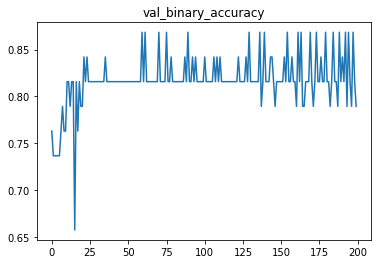

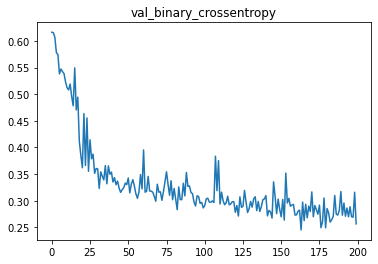

In [18]:
for k, hist in history.history.items():
    plt.plot(hist)
    plt.title(k)
    plt.show()